In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import json
import logging
import os
import click
import pickle
#import pycurl
#from io import BytesIO
import numpy as np
from datetime import datetime
#from datetime import timedelta
from sabcom.runner import runner
from sabcom.differential_equation_model import differential_equations_model
from sabcom.environment import Environment
from sabcom.helpers import generate_district_data, what_informality
from helpers.estimation import cost_function

In [2]:
#N = stats.norm(loc=mu, scale=sigma)

In [3]:
import scipy.stats as stats
stringency_index = 0.8

lower, upper = -stringency_index, (1 - stringency_index)
mu, sigma = 0.0, 1.0
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

In [4]:
stringency_index + X.rvs(1)[0]

0.9639203974622518

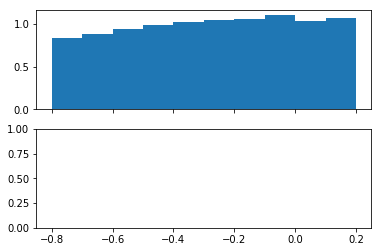

In [198]:
fig, ax = plt.subplots(2, sharex=True)
ax[0].hist(X.rvs(10000), normed=True)
#ax[1].hist(N.rvs(10000), normed=True)
plt.show()

# Estimating infections with the ABM

In [2]:
def simulate(**kwargs):
    """Simulate the model"""
    # format arguments
    seed = kwargs.get('seed')
    output_folder_path = kwargs.get('output_folder_path')

    input_folder_path = kwargs.get('input_folder_path')

    inititialisation_path = os.path.join(input_folder_path, 'initialisations')

    seed_path = os.path.join(inititialisation_path, 'seed_{}.pkl'.format(seed))

    if not os.path.exists(seed_path):
        click.echo(seed_path + ' not found', err=True)
        click.echo('Error: specify a valid seed')
        return

    data = open(seed_path, "rb")
    list_of_objects = pickle.load(data)
    environment = list_of_objects[0]

    # update optional parameters
    if kwargs.get('days'):
        max_time = environment.parameters['time']  # you cannot simulate longer than initialised
        environment.parameters['time'] = min(kwargs.get('days'), max_time)
        click.echo('Time has been set to {}'.format(environment.parameters['time']))
        logging.debug('Time has been set to {}'.format(environment.parameters['time']))

    if kwargs.get('probability_transmission'):
        environment.parameters['probability_transmission'] = kwargs.get('probability_transmission')
        click.echo('Transmission probability has been set to {}'.format(environment.parameters['probability_transmission']))
        logging.debug('Transmission probability has been set to {}'.format(environment.parameters['probability_transmission']))

    if kwargs.get('visiting_recurring_contacts_multiplier'):
        environment.parameters['visiting_recurring_contacts_multiplier'] = [kwargs.get('visiting_recurring_contacts_multiplier') for x in environment.parameters['visiting_recurring_contacts_multiplier']]
        click.echo('Recurring contacts has been set to {}'.format(environment.parameters['visiting_recurring_contacts_multiplier'][0]))
        logging.debug(
            'Recurring contacts has been set to {}'.format(environment.parameters['visiting_recurring_contacts_multiplier'][0]))

    if kwargs.get('likelihood_awareness'):
        environment.parameters['likelihood_awareness'] = [kwargs.get('likelihood_awareness') for x in environment.parameters['visiting_recurring_contacts_multiplier']]
        click.echo('Likelihood awareness has been set to {}'.format(environment.parameters['likelihood_awareness'][0]))
        logging.debug(
            'Likelihood awareness has been set to {}'.format(environment.parameters['likelihood_awareness'][0]))

    if kwargs.get('gathering_max_contacts'):
        environment.parameters['gathering_max_contacts'] = [kwargs.get('gathering_max_contacts') for x in environment.parameters['visiting_recurring_contacts_multiplier']]
        click.echo('Max contacts has been set to {}'.format(environment.parameters['gathering_max_contacts'][0]))
        logging.debug(
            'Max contacts has been set to {}'.format(environment.parameters['gathering_max_contacts'][0]))

    if kwargs.get('sensitivity_config_file_path'):
        # open file
        config_path = kwargs.get('sensitivity_config_file_path')
        if not os.path.exists(config_path):
            click.echo(config_path + ' not found', err=True)
            click.echo('Error: specify a valid path to the sensitivity config file')
            return
        else:
            with open(config_path) as json_file:
                config_file = json.load(json_file)

                for param in config_file:
                    environment.parameters[param] = config_file[param]

    # transform input data to general district data for simulations
    district_data = generate_district_data(environment.parameters['number_of_agents'], path=input_folder_path)

    # set scenario specific parameters
    scenario = kwargs.get('scenario', 'no-intervention')
    print('scenario is ', scenario)
    if scenario == 'no-intervention':
        environment.parameters['likelihood_awareness'] = [
            0.0 for x in environment.parameters['likelihood_awareness']]
        environment.parameters['visiting_recurring_contacts_multiplier'] = [
            1.0 for x in environment.parameters['visiting_recurring_contacts_multiplier']]
        environment.parameters['gathering_max_contacts'] = [
            float('inf') for x in environment.parameters['gathering_max_contacts']]
        environment.parameters['physical_distancing_multiplier'] = [
            1.0 for x in environment.parameters['physical_distancing_multiplier']]
        environment.parameters['informality_dummy'] = 0.0
    elif scenario == 'lockdown':
        environment.parameters['informality_dummy'] = 0.0
    elif scenario == 'ineffective-lockdown':
        environment.parameters['informality_dummy'] = 1.0

    # log parameters used after scenario called
    for param in environment.parameters:
        logging.debug('Parameter {} has the value {}'.format(param, environment.parameters[param]))

    for agent in environment.agents:
        agent.informality = what_informality(agent.district, district_data
                                             ) * environment.parameters["informality_dummy"]

    initial_infections = pd.read_csv(os.path.join(input_folder_path, 'f_initial_cases.csv'), index_col=0)

    # save csv light or network data
    data_output_mode = kwargs.get('data_output_mode', 'csv-light')  # default output mode is csv_light
    environment.parameters["data_output"] = data_output_mode

    environment = runner(environment=environment, initial_infections=initial_infections, seed=int(seed),
                         data_folder=output_folder_path,
                         data_output=data_output_mode)

    if data_output_mode == 'csv-light':
        pd.DataFrame(environment.infection_quantities).to_csv(os.path.join(output_folder_path,
                                                                           'seed{}quantities_state_time.csv'.format(seed)))
    return pd.DataFrame(environment.infection_quantities)

In [5]:
def abm_performance(input_params):
    """
    Simple function calibrate uncertain model parameters
    :param input_parameters: list of input parameters
    :return: cost
    """
    # update input parameters config file
    
    transmission_prob = input_params[0]
    
    
    
    # run model with parameters.
    df = simulate(input_folder_path='cape_town', output_folder_path='output_data/cape_town', seed=3,
                  data_output_mode='csv-light', scenario='ineffective-lockdown', days=350,
                  probability_transmission=transmission_prob)

   
    m_sim = {'dead': sim_dead}
    m_emp = {'dead':3680.6929047825934}

    # calculate the cost
    cost = cost_function(m_sim, m_emp)#quadratic_loss_function(stylized_facts_sim, empirical_moments, W)
    return cost

SyntaxError: invalid syntax (<ipython-input-5-b11a9dabb218>, line 18)

In [ ]:
input_folder_path='cape_town'

inititialisation_path = os.path.join(input_folder_path, 'initialisations')
seed_path = os.path.join(inititialisation_path, 'seed_{}.pkl'.format(3))

data = open(seed_path, "rb")
list_of_objects = pickle.load(data)
environment = list_of_objects[0]

In [ ]:
df = simulate(input_folder_path='cape_town', output_folder_path='output_data/cape_town', seed=2,
                  data_output_mode='csv-light', scenario='ineffective-lockdown', days=350,
                  probability_transmission=0.05)